In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-02-28 16:19:21.429384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-28 16:19:21.429400: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from LinearModel import LinearModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = LinearModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.LinearModel()

Epoch 1/10
 1/66 [..............................] - ETA: 7s - loss: 0.0174

2022-02-28 16:19:24.763318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 16:19:24.763690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-28 16:19:24.763732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-28 16:19:24.763768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-28 16:19:24.763802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 1ms/step - loss: 0.0174 - val_loss: 0.0175
Epoch 2/10
66/66 [==============================] - 0s 785us/step - loss: 0.0140 - val_loss: 0.0141
Epoch 3/10
66/66 [==============================] - 0s 661us/step - loss: 0.0117 - val_loss: 0.0117
Epoch 4/10
66/66 [==============================] - 0s 751us/step - loss: 0.0100 - val_loss: 0.0099
Epoch 5/10
66/66 [==============================] - 0s 622us/step - loss: 0.0087 - val_loss: 0.0086
Epoch 6/10
66/66 [==============================] - 0s 690us/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/10
66/66 [==============================] - 0s 669us/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
66/66 [==============================] - 0s 636us/step - loss: 0.0064 - val_loss: 0.0064
Epoch 9/10
66/66 [==============================] - 0s 689us/step - loss: 0.0060 - val_loss: 0.0060
Epoch 10/10
66/66 [==============================] - 0s 634us/step - loss: 0.0057 - val_loss: 0.0058


In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

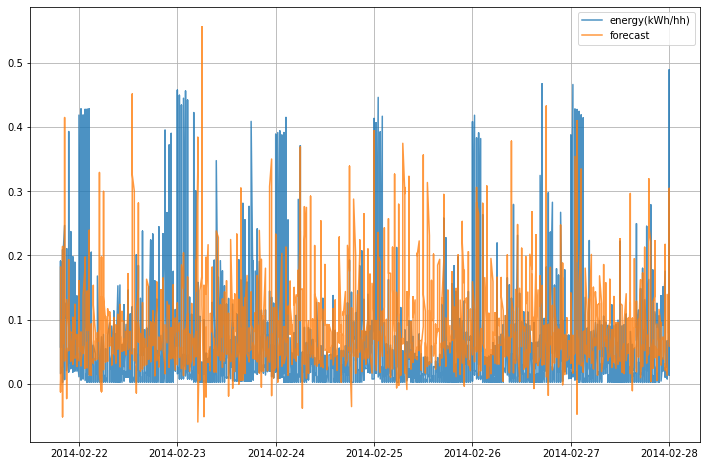

In [9]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_102324/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


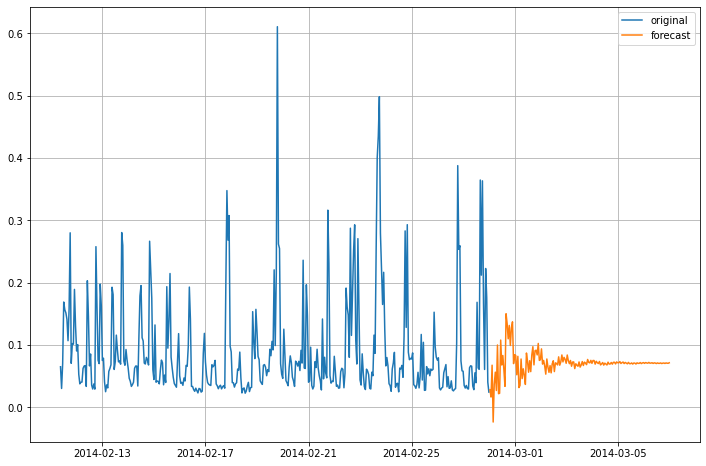

In [10]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [11]:
deep_learner.evaluateMSE()

0.005760095638399374

In [12]:
deep_learner.evaluateRMSE()

0.07589529391470445

In [13]:
deep_learner.evaluateMAE()

0.046561276000382526

In [14]:
deep_learner.evaluateMAPE()

53.194525339308086

In [15]:
yhat =deep_learner.predict()

In [16]:
yhat

[0.18184453,
 -0.012643844,
 0.10519264,
 0.0106539205,
 0.039584436,
 -0.005529739,
 0.10070319,
 -0.05139207,
 0.14093487,
 0.21400407,
 0.14100805,
 0.05066639,
 0.011210298,
 0.097782575,
 0.1672247,
 0.06219948,
 0.108813934,
 0.22308877,
 0.4149009,
 0.35755306,
 0.1942577,
 0.15289512,
 0.23057029,
 0.07949123,
 0.07809034,
 0.03553231,
 0.05579614,
 0.035936676,
 0.03974638,
 -0.02286338,
 0.0669231,
 0.097101785,
 0.06337491,
 0.028167438,
 0.06380318,
 0.13131455,
 0.088063166,
 0.05182954,
 0.101215124,
 0.19345155,
 0.17079619,
 0.14381506,
 0.059163667,
 0.07634328,
 0.07510523,
 0.106763825,
 0.065135166,
 0.06516924,
 0.054885104,
 0.04174197,
 0.048665907,
 0.06197668,
 0.036354143,
 0.03545913,
 0.045717087,
 0.080451876,
 0.07938151,
 0.039607592,
 0.03051415,
 0.06279873,
 0.098122664,
 0.10360377,
 0.08185727,
 0.056443084,
 0.082195245,
 0.057414204,
 0.07252542,
 0.099460155,
 0.08092709,
 0.084376544,
 0.12384716,
 0.0919613,
 0.0998448,
 0.06305906,
 0.07479615,